In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from xarray.core.alignment import align

from project.test_pendulum import *
from project.lim import LIM
from project.util import *

In [3]:
def make_dataset():
    tt, xx, yy = run_oscillator(t_end=800, sigma=0.0001)

    ds = xr.Dataset(
        {
            "x": (["time"], yy[0, :]),
            "v": (["time"], yy[1, :]),
        },
        coords={"time": tt},
    )

    return ds, yy


ds, xx = make_dataset()
ds

G: [[ 0.99950037  0.09988342]
 [-0.00998834  0.99750271]]
Eigenvalues of G: [0.99850154+0.03157011j 0.99850154-0.03157011j]
L: [[ 0.    1.  ]
 [-0.1  -0.02]]
Eigenvalues of L: [-0.01+0.31606961j -0.01-0.31606961j]


<xarray.Dataset>
Dimensions:  (time: 8000)
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 ... 799.6 799.7 799.8 799.9
Data variables:
    x        (time) float64 1.0 1.0 0.999 ... 3.952e-05 -0.0007174 -0.001078
    v        (time) float64 7.66e-05 -0.009985 -0.01993 ... -0.005767 -0.005508

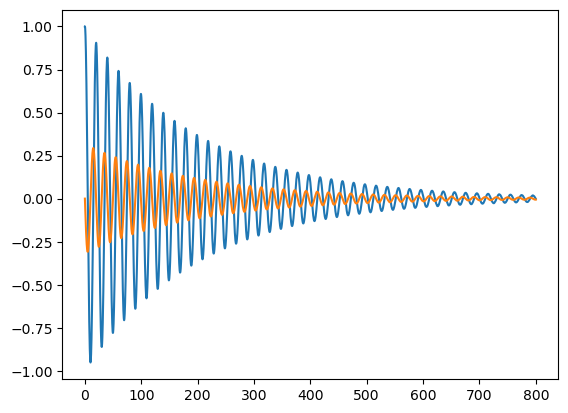

In [4]:
plt.plot(ds.time, ds["x"])
plt.plot(ds.time, ds["v"])

plt.show()

In [5]:
lim = LIM()
lim.fit(ds)
lim.print_properties()

G1: [[ 0.99999985  0.10000068]
 [-0.01000009  0.99799813]]
Eigenvalues of G: [0.99899899+0.03160718j 0.99899899-0.03160718j]
L: [[ 0.00500271+9.36427025e-17j  1.00067506+3.14664931e-17j]
 [-0.10006771-1.08019997e-18j -0.01502786+6.94565277e-18j]]
Eigenvalues of L: [-0.00501258+0.31628304j -0.00501258-0.31628304j]
Eigenvalues of Q: [1.24904284e-03 1.65348825e-07]


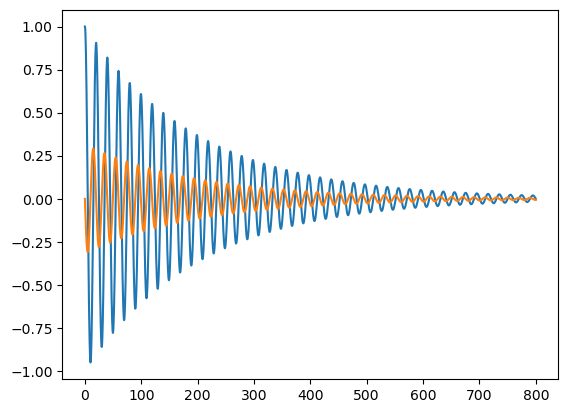

In [6]:
tt2, xx2 = lim.forecast_np(np.array([1, 0]), int(800 / 0.1))

plt.plot(tt2, xx2[0, :])
plt.plot(tt2, xx2[1, :])

<xarray.Dataset>
Dimensions:  (time: 8001)
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 ... 799.7 799.8 799.9 800.0
Data variables:
    v        (time) float64 dask.array<chunksize=(8001,), meta=np.ndarray>
    x        (time) float64 dask.array<chunksize=(8001,), meta=np.ndarray>

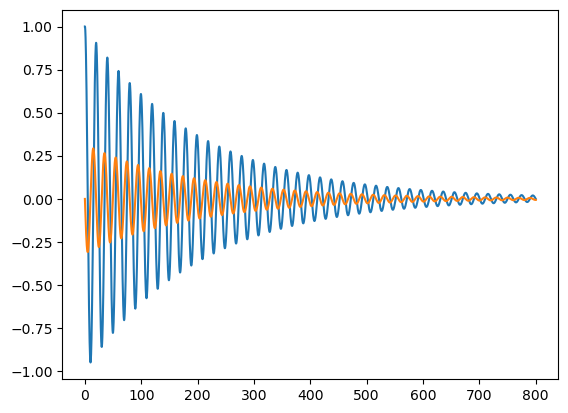

In [7]:
fc = lim.forecast_deterministic(
    xr.Dataset({"x": (["time"], [1.0]), "v": (["time"], [0.0])}, coords={"time": [0.0]}),
    int(800 / 0.1),
    0,
)

plt.plot(fc.time, fc["x"])
plt.plot(fc.time, fc["v"])
fc

<xarray.Dataset>
Dimensions:  (time: 1)
Coordinates:
  * time     (time) float64 0.0
Data variables:
    x        (time) float64 1.0
    v        (time) float64 0.0


  0%|          | 0/4000001 [00:00<?, ?it/s]

100%|██████████| 4000001/4000001 [02:31<00:00, 26479.62it/s]


<xarray.Dataset>
Dimensions:  (time: 8001)
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 ... 799.7 799.8 799.9 800.0
Data variables:
    v        (time) float64 dask.array<chunksize=(8001,), meta=np.ndarray>
    x        (time) float64 dask.array<chunksize=(8001,), meta=np.ndarray>

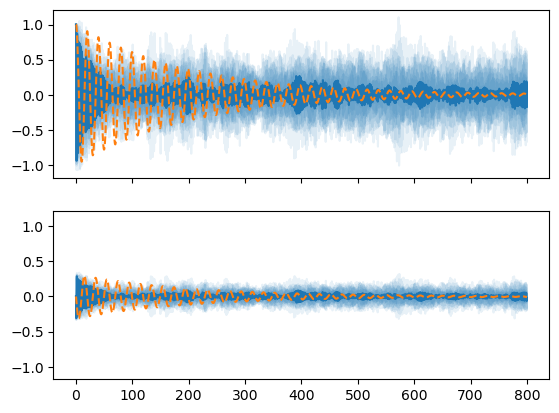

In [8]:
fc_stoch = lim.forecast_stochastic(
    xr.Dataset({"x": (["time"], [1.0]), "v": (["time"], [0.0])}, coords={"time": [0.0]}),
    int(800 / 0.1),
    10,
    500,
    0,
)

fig, axs = plt.subplots(2, sharex=True, sharey=True)

for i in range(10):
    axs[0].plot(fc.time, fc_stoch["x"].isel(ens=i), c="C0", alpha=0.1)
    axs[1].plot(fc.time, fc_stoch["v"].isel(ens=i), c="C0", alpha=0.1)

axs[0].plot(fc.time, fc_stoch["x"].mean("ens"))
axs[1].plot(fc.time, fc_stoch["v"].mean("ens"))

axs[0].plot(fc.time, fc["x"], ls="--")
axs[1].plot(fc.time, fc["v"], ls="--")

fc